In [1]:
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import pandas as pd
from collections import deque
import numpy as np

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from collections import Counter, OrderedDict

In [30]:
from nltk.parse.corenlp import CoreNLPDependencyParser

In [23]:
# java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000

In [4]:
def append_to_queue(q, key, val):
    if key not in q:
        q[key] = deque([val])
    else:
        q[key].append(val)
    return q

In [5]:
def get_from_queue(q, key):
    if key not in q:
        return key
    else:
        if len(q[key]) == 0:
            return key
        return q[key].popleft()

In [6]:
def res_to_string(s):
    res = []
    for key, val in s.items():
        for v in val:
            res.append(v + ' ' + key)
    return res

In [31]:
def find_amod(sentence):
    try:
        used_nouns = set()
        used_adj = set()
        idpend = set()
        res = {}
        nons_queue = {}
        conjs_queue = {}
        dep_parser = CoreNLPDependencyParser(url='http://localhost:9000')
        parse, = dep_parser.raw_parse(sentence)
        #parse compound
        for governor, dep, dependent in parse.triples():
            if dep == 'conj':
                if governor[1] in ('JJ','JJS') and dependent[1] in ('JJ','JJS'):
                    conjs_queue = append_to_queue(conjs_queue, governor[0], dependent[0])
                    used_adj.add(governor[0])
                    used_adj.add(dependent[0])
            if dep == 'compound':
                if governor[1] in ('NN','NNS') and dependent[1] in ('NN','NNS'):
                    nons_queue = append_to_queue(nons_queue, dependent[0], dependent[0] + ' ' + governor[0])
                    used_nouns.add(governor[0])
                    used_nouns.add(dependent[0])

        #print(conjs_queue)

        for governor, dep, dependent in parse.triples():
            #print(governor, dep, dependent)
            if dep == 'amod':
                if governor[1] in ('NN','NNS'):
                    if dependent[1] in ('JJ', 'JJS'):
                        tmp_non = get_from_queue(nons_queue, governor[0])
                        if tmp_non not in res:
                            res[tmp_non] = set([dependent[0]])
                        else:
                            res[tmp_non].add(dependent[0])
                            
                        used_adj.add(dependent[0])
                        used_nouns.add(tmp_non)
                        
                        jj = get_from_queue(conjs_queue, dependent[0])
                        if jj != dependent[0]:
                            res[tmp_non].add(jj)
                            used_nouns.add(jj)
                            
            if dep == 'nsubj':
                if dependent[1] in ('NN','NNS'):
                    if governor[1] in ('JJ', 'JJS'):
                        tmp_non = get_from_queue(nons_queue, dependent[0])
                        if tmp_non not in res:
                            res[tmp_non] = set([governor[0]])
                        else:
                            res[tmp_non].add(governor[0])
                            
                        used_adj.add(governor[0])
                        used_nouns.add(tmp_non)
                        
                        jj = get_from_queue(conjs_queue, governor[0])
                        if jj != governor[0]:
                            res[tmp_non].add(jj)
                            used_adj.add(jj)
        
        for governor, dep, dependent in parse.triples():
            if governor[1] in ('NN','NNS') and (governor[0] not in used_nouns):
                idpend.add(governor[0])
                used_nouns.add(governor[0])
            if dependent[1] in ('NN','NNS') and (dependent[0] not in used_nouns):
                idpend.add(dependent[0])
                used_nouns.add(dependent[0])
            if governor[1] in ('JJ', 'JJS') and (governor[0] not in used_adj):
                idpend.add(governor[0])
                used_adj.add(governor[0])
            if dependent[1] in ('JJ', 'JJS') and (dependent[0] not in used_adj):
                idpend.add(dependent[0])
                used_adj.add(dependent[0])
                
        return res_to_string(res) + list(idpend)
    except Exception as e:
        print(e)
        return None

In [32]:
find_amod('Just the right mix of urban center and local neighborhood; close to all but enough quiet for a calming walk.')

['right mix',
 'urban center',
 'local neighborhood',
 'quiet',
 'close',
 'walk',
 'enough']

In [33]:
df = pd.read_csv('listings.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (43,61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
unique_df = df.drop_duplicates(subset=['neighborhood_overview'])

In [35]:
def to_lower_ch(x):
    try:
        return x.lower()
    except:
        return x

In [36]:
#lower case
unique_df.loc[:, 'neighborhood_overview'] = unique_df['neighborhood_overview'].apply(lambda x: to_lower_ch(x))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [37]:
unique_df['analysis'] = unique_df['neighborhood_overview'].apply(lambda x: find_amod(x))

sequence item 0: expected str instance, float found


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
import pickle

with open('result.pickle', 'wb') as handle:
    pickle.dump(unique_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
unique_df_nonone = unique_df[unique_df['analysis'].apply(lambda x: x is not None)]

In [40]:
unique_df_nonone.shape

(27398, 107)

In [41]:
v = DictVectorizer()
sparse_matrix = v.fit_transform(Counter(f) for f in unique_df_nonone['analysis'])

In [42]:
res = pd.DataFrame(sparse_matrix.toarray(), columns=v.get_feature_names())

In [43]:
row_sum_res = res.sum(axis=1)

In [44]:
tf_res = res.div(row_sum_res, axis=0)

In [45]:
tf_res.head(1).loc[:, tf_res.head(1).any()]

,blocks,bryant park,desirable location,few minutes,heart,manhattan,square times
0,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


In [46]:
column_sum_res = res.sum(axis=0)

In [47]:
idf_res = column_sum_res.apply(lambda x: np.log(unique_df_nonone.shape[0] / x))

In [48]:
tf_idf_res = res.multiply(idf_res, axis=1)

In [49]:
tf_idf_res.head(1).loc[:, tf_idf_res.head(1).any()]

,blocks,bryant park,desirable location,few minutes,heart,manhattan,square times
0,2.285863,5.298244,8.426466,4.976478,2.889788,2.244725,3.839799


In [50]:
tf_idf_res.head()

,#,#easy access,#games,#thecoolestplaceonearth,%,'30s,'60s,'70s,'80s,'90s,...,面包店,韓式,韩餐,餐厅,餐饮非常方便,餐馆,马来西亚,鬧中取靜,麦当劳,ﾄﾞﾗｯｸﾞｽﾄｱが3角形状にあり上記全部徒歩5分圏内でいけます
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [52]:
isEnglish('world hello 你')

False

In [53]:
t_lst = []
for _ in list(tf_idf_res.columns):
    if isEnglish(_):
        t_lst.append(_)

In [54]:
tf_idf_res = tf_idf_res[t_lst]

In [63]:
#kmeans = KMeans(n_clusters=6).fit(tf_idf_res)
kmeans = KMeans(n_clusters=6).fit(tf_idf_res)

In [64]:
Sum_of_squared_distances = []
K = range(5,10)
for k in K:
    km = MiniBatchKMeans(n_clusters=k)
    km = km.fit(tf_idf_res)
    Sum_of_squared_distances.append(km.inertia_)


KeyboardInterrupt: 

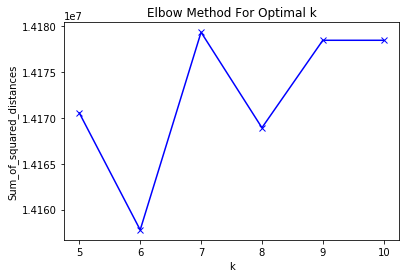

In [62]:
import matplotlib.pyplot as plt
Sum_of_squared_distances.append(km.inertia_)

plt.plot([5,6,7,8,9,10], Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [65]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = list(tf_idf_res.columns)

for i in range(6):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :9]:
        print(' %s' % terms[ind])

Cluster 0:
 greatest location
 popular train
 real estate location
 long island railroad
 amazing access
 lirr
 great shopping
 local shops
 great shops
Cluster 1:
 fantastic grocer
 ave-esque brownstones
 massive avenues
 adorable slope
 par
 upstate
 friendly bars
 central park slope
 dog
Cluster 2:
 warm neighbors
 assistance
 local restaurant
 favorite restaurant
 directions
 friendly neighbors
 single owner
 single homes
 owner
Cluster 3:
 classic locales
 favorite c
 bedstuy locales
 quartet
 typical destination
 weekly night life
 local locales
 wonderful bar lunatico
 favorite dining
Cluster 4:
 restaurants
 bars
 neighborhood
 minutes
 apartment
 manhattan
 block
 blocks
 central park
Cluster 5:
 museum
 botanical gardens
 music
 bam
 center
 bars
 botanic garden
 public library
 grand army plaza


In [ ]:
class Config(object):
    DEBUG = False
    TESTING = False
    DATABASE = {
        'drivername': 'postgres',
        'host': 'zheyu-database-airbnb.cu2ky11rrces.us-east-2.rds.amazonaws.com',
        'port': '5432',
        'username': 'zheyu',
        'password': 'zheyuliu',
        'database': 'airbnb'
    }

In [ ]:
engine = create_engine(URL(**Config.DATABASE))

In [ ]:
qry = '''
SELECT id, name, summary, space, description, neighborhood_overview, transit, access, neighbourhood, neighbourhood_cleansed, zipcode, market, latitude, longitude, room_type, property_type, number_of_reviews, review_scores_rating, review_scores_location, neighborhood_overview_processed, cluster FROM dbo.listings;
'''

In [ ]:
df = pd.read_sql(qry, engine)

In [ ]:
df.loc[3, 'neighborhood_overview']

In [ ]:
df.loc[120, 'neighborhood_overview']